# Ad Generation using Auto Encoder

This notebook aims to test how machine learning model performs to design challenges, where given a bunch of bounding boxes blueprint, can it improve upon new designs?

This notebook aims to test that. 

First of all there is the ImageManager which contains all the image extraction methods from dataset, including cleaning and converting it to numpy form for faster access.

Second comes in the VAE. To train the vae simply import from helper and send it the image manager. 

To test it, use the method, restore_and_test functionality in vae in helper.

Finally creating new designs and testing the improvement on them can also be done using interactive toolbars created in this notebook

# Libraries to be imported

In [9]:
from matplotlib.widgets  import RectangleSelector

from helper.config import *

import tensorflow as tf

from ipywidgets import *
from IPython.display import display
from IPython.html import widgets

%matplotlib notebook
import os

import cv2
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import sys

from tqdm import tnrange, tqdm_notebook
from helper.image_manager import ImageManager
from pprint import pprint

import helper.vae as vae

# Retreive images from dataset

In [2]:
%%time

image_manager = ImageManager(0, 1)
test_image_manager = ImageManager(7, 8)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



CPU times: user 32.8 ms, sys: 1.53 s, total: 1.56 s
Wall time: 3.95 s


# Visualize one image and its masks

In [3]:
NUM_BYTES_FOR_MASK = image_manager.num_mask

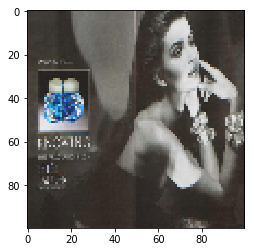

Layer: Text


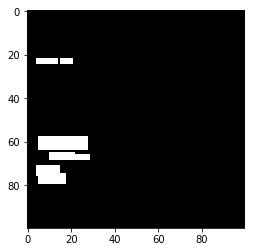

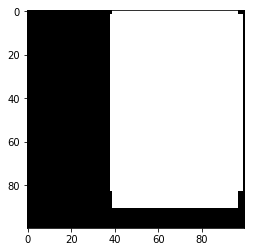

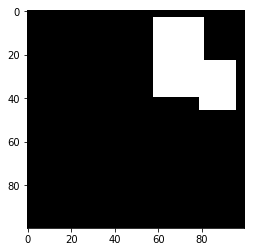

In [4]:
%matplotlib inline
img_mask = image_manager.files[5].reshape([100, 100, NUM_BYTES_FOR_MASK])
folder_path = os.path.join(image_manager.folder_path, '0')
img = cv2.imread(os.path.join(folder_path, os.listdir(folder_path)[5]))
img = cv2.resize(img, (100,100))

plt.figure()
plt.imshow(img)
plt.show()

plt.figure()
print('Layer: Text')
plt.imshow(img_mask[:,:,0], origin="upper", cmap="gray")
plt.show()
        
for i in range(1,NUM_BYTES_FOR_MASK):
    if np.count_nonzero(img_mask[:,:,i])>0:
#         print('Layer:',clustered_classes[i-1])
        fig = plt.figure()
        plt.imshow(img_mask[:,:,i], origin="upper", cmap="gray")
        plt.show()

# BETA VARIATIONAL AUTOENCODER

In [11]:
import imp
imp.reload(vae)

<module 'helper.vae' from '/gpfs/home/asamanta/Myriad-Ad-Generation/helper/vae.py'>

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Saved model at: /gpfs/scratch/asamanta/models/vae_1024_128_40_sigmoid_adam/model.ckpt
24.4088521438
Original Images vs Reconstructed Images
Layer: 0


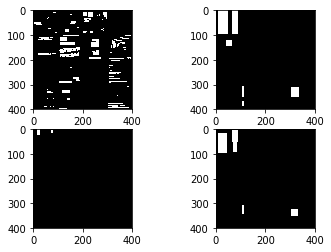

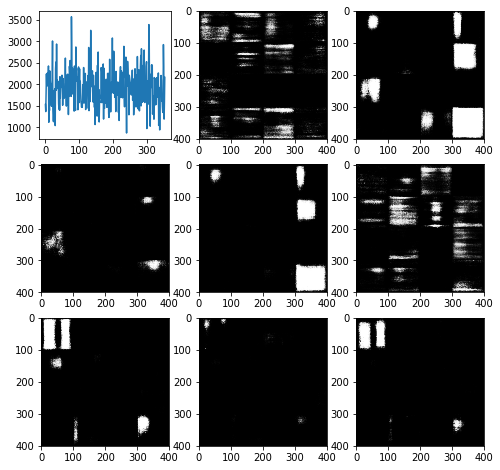

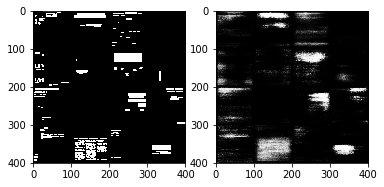

Layer: 1


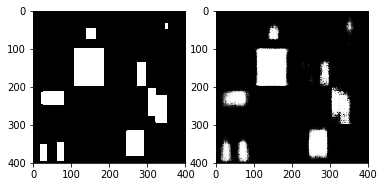

Layer: 2


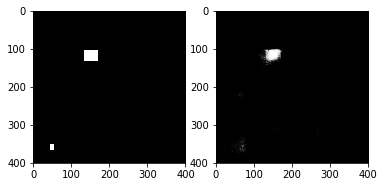

Layer: 3


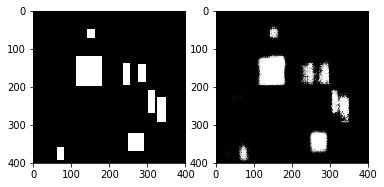

[4266.1343, 3363.9854, 3116.2131, 2839.6074, 2743.9146, 2606.4731, 2522.1458, 2503.9285, 2458.4861, 2379.751, 2366.3154, 2343.1865, 2265.5117, 2351.8467, 2282.3635, 2313.4165, 2373.2031, 2378.8508, 2298.2366, 2267.0342]


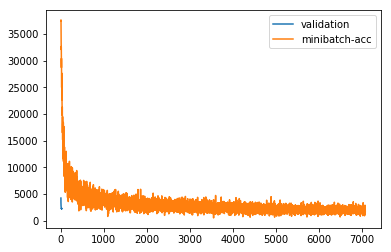

In [12]:
vae.train(image_manager, test_image_manager)

In [ ]:
vae.restore_and_test(test_image_manager)

# GENERATING Designs

In [5]:
rect_colors = {'2':'#00FF00', '3':'#0000ff', '4':'#ff0000', '1': '#000000'}
color_tuples = {'2':[0,255,0], '3':[0,0,255], '4':[255,0,0], '1': [0,0,0]}
layers = {'2':2, '3':1, '4':3, '1':0}
layer_names = {'2':'Human', '3':'Body part', '4':'Vehicle', '1':'Text'}

In [7]:
def toggle_selector(event):
    global ax, key_list
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['R', 'r']:
        print(' RectangleSelector reset.')
        ax.cla()
        ax.set_ylim(0,100)
        ax.set_xlim(0,100)
    if event.key in rect_colors.keys():
        ax.set_title('Class:'+layer_names[event.key])
        print('Class', event.key)
        key_list.append(event.key)

In [8]:
def line_select_callback(eclick, erelease):
    global ax, event_list
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    try:
        color = rect_colors[key_list[-1]]
    except:
        color = rect_colors['1']
    rect = plt.Rectangle((min(x1,x2),min(y1,y2)), np.abs(x1-x2), np.abs(y1-y2), color=color)
    event_list.append((key_list[-1], int(min(x1,x2)),int(min(y1,y2)), int(np.abs(x1-x2)), int(np.abs(y1-y2))))

    ax.add_patch(rect)

<IPython.core.display.Javascript object>


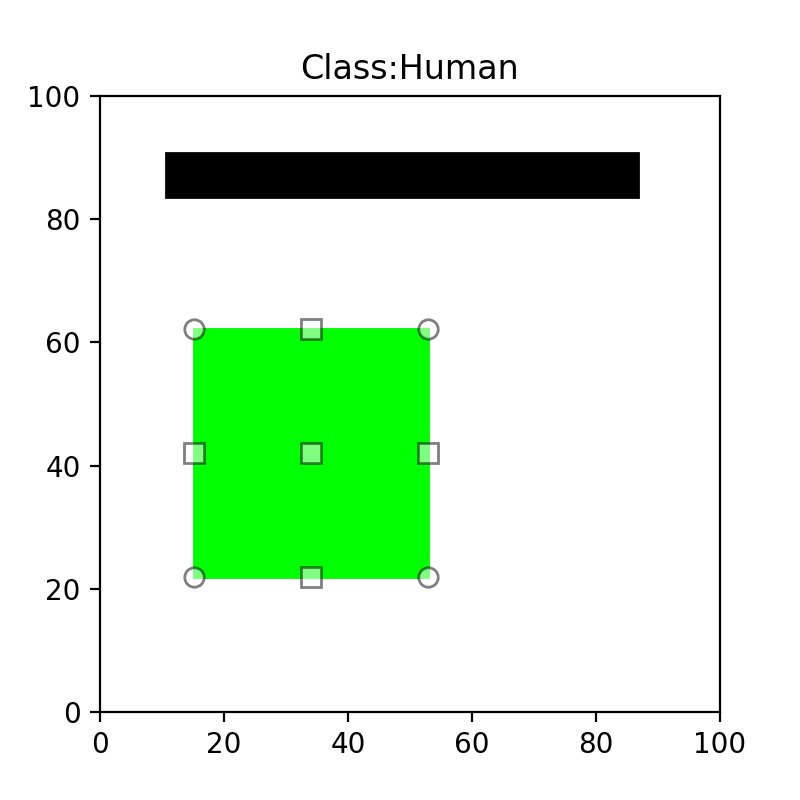

In [12]:
%matplotlib notebook
xdata = np.linspace(0,100, num=100)
ydata = np.linspace(0,100, num=100)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylim(0,100)
ax.set_xlim(0,100)
event_list = []
key_list = []

rs = RectangleSelector(ax, line_select_callback,
                       drawtype='box', useblit=True, button=[1], 
                       minspanx=5, minspany=5, spancoords='pixels', 
                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()

In [13]:
NUM_BYTES_FOR_MASK = 3+1

In [14]:
test_image = np.zeros((1,100,100,NUM_BYTES_FOR_MASK), dtype=np.uint8)
for key, x, y, dx, dy in event_list:
    test_image[0, 100-y-dy:100-y, x:x+dx,layers[key]] = 1

img_mask = test_image[0]

In [15]:
dim_ = 100

# Image test set
batch_x = test_image
batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float32)

orig_img = np.ones(shape=(100,100,3), dtype=np.uint8)*255
recons_img = np.ones(shape=(100,100,3), dtype=np.uint8)*255
mod_img = np.ones(shape=(100,100,3), dtype=np.uint8)*255

<IPython.core.display.Javascript object>


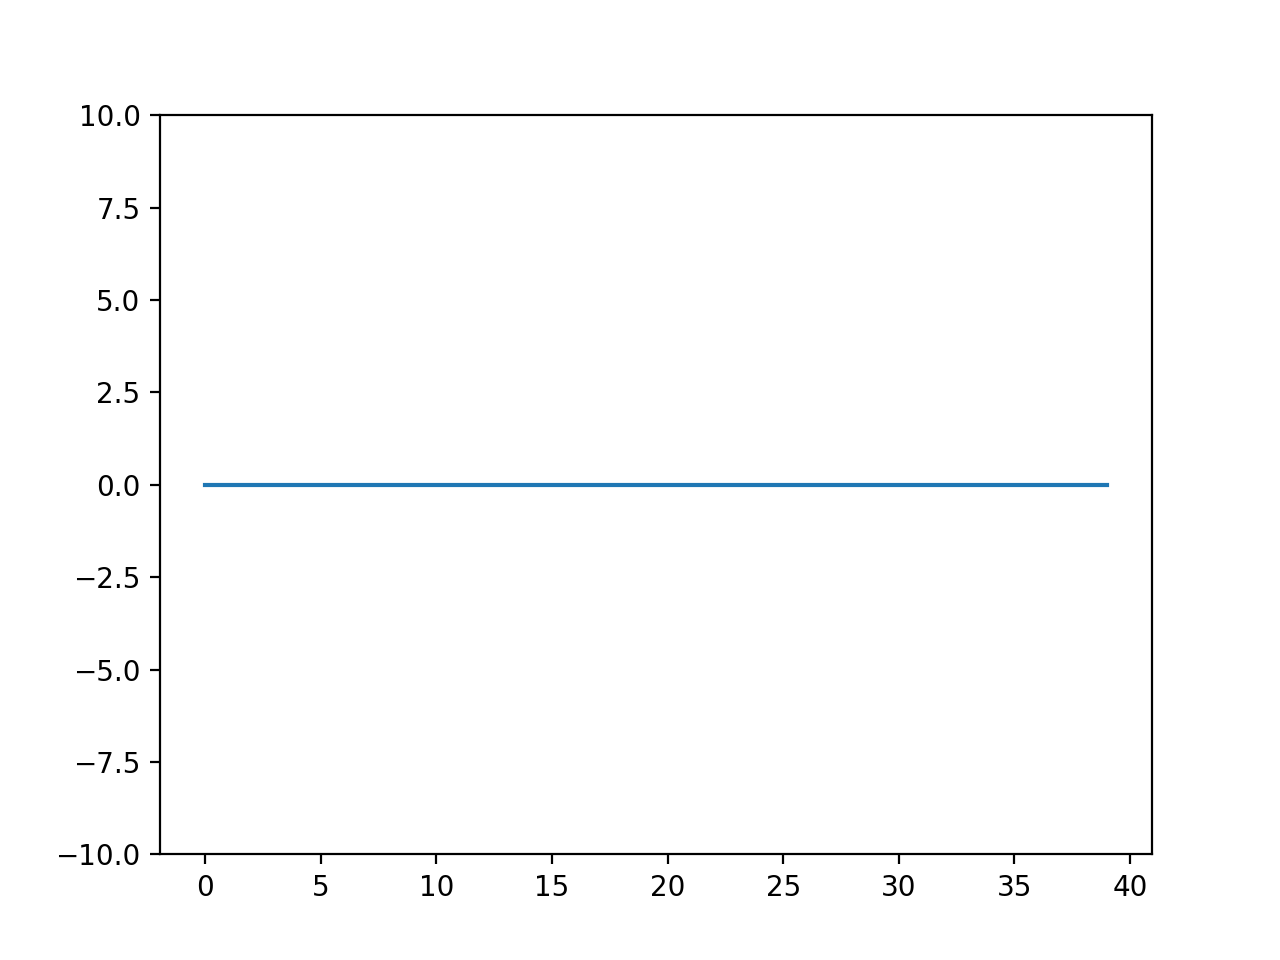

44.4859528391


<IPython.core.display.Javascript object>


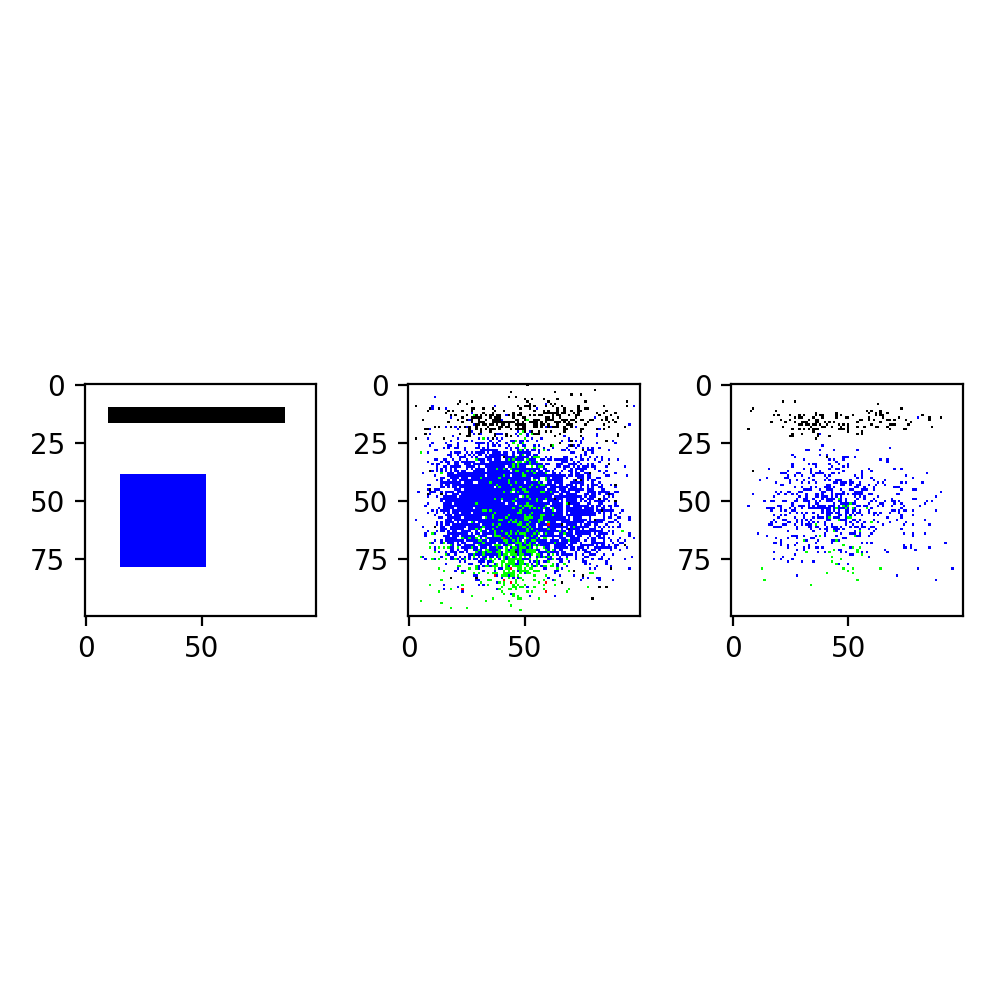

Original Images vs Reconstructed Images


In [44]:
%matplotlib notebook
# Encode and decode the digit image
latent_dim = 40
output, ip_img, hidden, sess =  vae.get_model_tensors()
encoded_output = hidden.eval(feed_dict={ip_img: batch_x},session=sess)
g = output.eval(feed_dict={hidden: encoded_output},session=sess)

mod_value_list = np.zeros((latent_dim), dtype=np.float32)



def create_new_image(mod_value=0):
    global mod_dim, mod_value_list
    mod_value_list[mod_dim] = mod_value
    temp_encoded_output = encoded_output.copy()
    temp_encoded_output[0][mod_dim] += mod_value_list[mod_dim]
    ax.clear()
    ax.plot(mod_value_list)
    ax.set_title('Modification value')
    fig.show()
    mod_g = output.eval(feed_dict={hidden: temp_encoded_output}, session=sess)
    canvas_mod = np.round(mod_g).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    mod_img[:,:,:] = 255
    for i in range(NUM_BYTES_FOR_MASK):
        mod_img[(canvas_mod[:,:,i]==1)] = color_tuples[str(i+1)]
        axarr[2].clear()
        axarr[2].imshow(mod_img)
    plt.tight_layout()
    plt.show()

mod_dim = 0

interact(create_new_image, mod_value=widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=0.0))
interact(change_dim, input_dim=widgets.IntSlider(min=0,max=latent_dim,step=1,value=0))

def change_dim(input_dim=0):
    global mod_dim
    mod_dim = input_dim
    create_new_image(0)
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(mod_value_list)
ax.set_ylim(-10,10)

canvas_orig = np.round(batch_x).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
canvas_recon = np.round(g).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
canvas_mod = np.round(g).astype(int).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
print(np.linalg.norm(canvas_orig - canvas_recon))

f, axarr = plt.subplots(1,3, figsize=(5,5))
print("Original Images vs Reconstructed Images")  
for i in range(NUM_BYTES_FOR_MASK):
    orig_img[(canvas_orig[:,:,i]==1)] = color_tuples[str(i+1)]
    mod_img[(canvas_recon[:,:,i]==1)] = color_tuples[str(i+1)]
    recons_img[(canvas_mod[:,:,i]==1)] = color_tuples[str(i+1)]
axarr[0].imshow(orig_img)
axarr[1].imshow(recons_img)
axarr[2].imshow(mod_img) 
plt.tight_layout()
f.show()
# fig.show()